In [1]:
# default_exp pytorch_tensorrt_conversion

As of `TensorRT-7.2.0.14` converting the original pytorch fiducial detect network to TensorRT results in different inference results. I believe it might be due to the `Upsample` layer in the decoder, although I'm not sure. So instead, what I'm going to do is take the approach of creating the model first, converting it to TensorRT, then seeing if the results are the same before I start training.

In [2]:
#export
import torch
from torch import nn

In [3]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

# Create model

The TensorRT documentation specifically states that `InstanceNorm` and `ConvTranspose2d` are supported layers, so I'm gonna modify the previous network I used to use these operations instead. I'm also going to modify to try to ensure dimensions are multiples of 16 as per recommended practice to ensure tensorcores are used.

In [4]:
#export
def get_out_channels(m):
    # Gets out_channels of last conv layer
    out_channels = None
    for m_sub in m.modules():
        if isinstance(m_sub, nn.modules.conv._ConvNd):
            out_channels = m_sub.out_channels
    return out_channels

In [5]:
#export
def conv_layer(in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, 
                  out_channels, 
                  kernel_size=kernel_size, 
                  stride=stride, 
                  padding=padding, 
                  bias=False), # No bias needed since learnable affine params in norm layer
        nn.InstanceNorm2d(out_channels, affine=True),
        nn.ReLU(inplace=True)
    )

In [6]:
#export
def up_conv_layer(in_channels, out_channels, kernel_size, stride, padding, scale_factor):
    return nn.Sequential(
        conv_layer(in_channels, out_channels, kernel_size, stride, padding),
        nn.ConvTranspose2d(out_channels, out_channels, kernel_size=2, stride=2)
    )

In [7]:
#export
def get_encoder(in_channels, layout_encoder):
    prev_out_channels = in_channels
    encoder = []
    for layout_layer in layout_encoder:
        layer = []
        for layout_conv in layout_layer:
            layer.append(conv_layer(prev_out_channels, *layout_conv))
            prev_out_channels = layout_conv[0]
        encoder.append(nn.Sequential(*layer))
    return nn.Sequential(*encoder)

In [8]:
#export
class UNET_TRT(nn.Module):
    def __init__(self, encoder, out_channels):
        super(UNET_TRT, self).__init__()
        self.encoder = encoder
        self.decoder = self._get_decoder(encoder)
        self.last_conv = nn.Conv2d(get_out_channels(self.decoder), 
                                   out_channels, 
                                   kernel_size=3, 
                                   stride=1, 
                                   padding=1)
        
    def _get_decoder(self, encoder):
        # Assumes each level of encoder shrinks by a factor of 2
        decoder = []
        for i in reversed(range(len(encoder))):
            in_channels = get_out_channels(encoder[i])
            if len(decoder) > 0: 
                in_channels += get_out_channels(decoder[-1])
            decoder.append(up_conv_layer(in_channels,
                                         get_out_channels(encoder[i])//2,
                                         kernel_size=3,
                                         stride=1,
                                         padding=1,
                                         scale_factor=2))
        return nn.Sequential(*decoder)

    def forward(self, X):
        Xs = [X]
        for conv_down in self.encoder:
            Xs.append(conv_down(Xs[-1]))
        X = Xs[-1][:,0:0,:,:] # Empty, but same size and dimension as last X
        for idx, conv_up in enumerate(self.decoder):
            X = conv_up(torch.cat([X, Xs[-(idx+1)]], dim=1))
        return self.last_conv(X)

In [9]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[32,5,2,2]],
                  [[32,3,1,1],[32,3,2,1]],
                  [[64,3,1,1],[64,3,2,1]],
                  [[128,3,1,1],[128,3,2,1]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)

In [10]:
model = model.to('cuda')
model = model.eval()

Check model

In [11]:
model

UNET_TRT(
  (encoder): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
      (1): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): Sequential(
      (0): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNor

According to documentation, channel sizes and batch sizes which are multiples of 16 will help ensure tensorcore instructions are used, which is true for all convolutions except for the last layer.

Now, check inference real quick

In [12]:
X = np.fromfile('batches/X0.raw', dtype=np.float32).reshape(1, 1, 384, 512)
X = torch.from_numpy(X).cuda()

In [13]:
torch.set_grad_enabled(False) 

In [14]:
y = model(X)
torch.cuda.synchronize()

In [15]:
%%timeit
y = model(X)
torch.cuda.synchronize()

4.61 ms ± 27.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
y[0,0,0,0].item()

0.00858943909406662

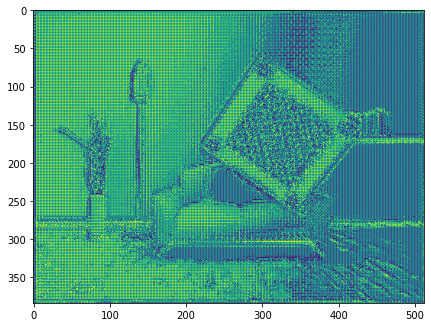

In [17]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(dim=1)[0].cpu().numpy(), vmin=0, vmax=4)

# Convert to onnx

In [18]:
import onnx
import torch.onnx
import onnxruntime as nxrun

In [19]:
torch.onnx.export(model,
                  X,
                  'model.onnx',
                  export_params=True,
                  verbose=False)

In [20]:
sess = nxrun.InferenceSession('model.onnx')
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
y = sess.run(None, {input_name: X.cpu().numpy()})[0]

In [21]:
y[0,0,0,0].item()

0.008589398115873337

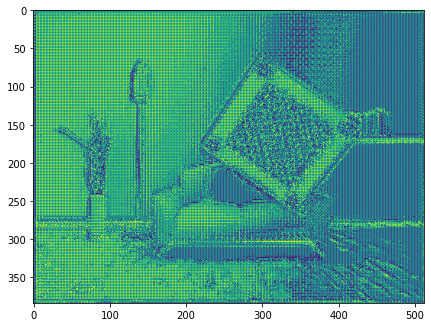

In [22]:
plt.figure(figsize=(7, 7))
plt.imshow(y.argmax(axis=1)[0], vmin=0, vmax=4)

# Onnx to tensorrt (32 bit)

In [4]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [5]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create engine

In [6]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 16
engine = builder.build_engine(network, config)

Save engine

In [7]:
with open('model_32.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [8]:
runtime = trt.Runtime(logger)
with open('model_32.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [9]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [10]:
with open('batches/X0.raw', 'rb') as f:
    f.readinto(X_h)

In [11]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [12]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize() 

In [13]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [14]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

2.75 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [16]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [17]:
y_h[0][0][0][0].item()

0.008589476346969604

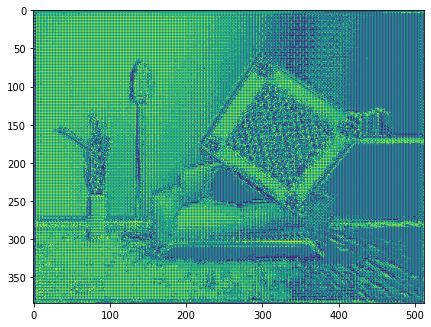

In [18]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

# Onnx to tensorrt (16 bit)

In [5]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [6]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create engine

In [7]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 16
config.set_flag(trt.BuilderFlag.FP16)
# config.set_flag(trt.BuilderFlag.STRICT_TYPES) # This will force it
engine = builder.build_engine(network, config)

Save engine

In [8]:
with open('model_16.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [9]:
runtime = trt.Runtime(logger)
with open('model_16.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [10]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [11]:
with open('batches/X0.raw', 'rb') as f:
    f.readinto(X_h)

In [12]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [13]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize() 

In [14]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [15]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

2.03 ms ± 77.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [17]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [18]:
y_h[0][0][0][0].item()

0.008575439453125

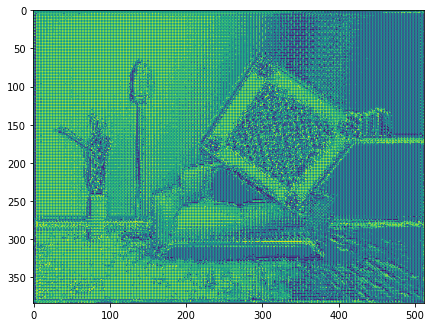

In [19]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

As a side note, performing inference and running `nvprof` reveals:
    
![tensorcores](https://i.imgur.com/t7wcQMn.png)

The h1688cudnn are tensorcore instructions. Since the python script loads the data, transfers it to device, does inference, then copies it back, its hard to tell specifically how much time inference takes, but it is confirmed that tensorcores are actually being used.

# Onnx to tensorrt (8 bit)

This is a little more complicated and requires doing 8 bit calibration

In [4]:
import pycuda.autoinit
import pycuda.driver as cuda

import tensorrt as trt

In [5]:
logger = trt.Logger(trt.Logger.VERBOSE)

Create calibrator; documentation says Entropy Calibrator V2 is the recommended version for CNN based networks. It would be interesting to see how much of an effect calibration has on results.

In [6]:
class Int8Calibrator(trt.IInt8EntropyCalibrator2):
    def __init__(self, files_batch):
        super().__init__()
        self.files_batch = files_batch
        self.count = 0
        self.buf_h = cuda.pagelocked_empty(384*512, dtype=np.float32)
        self.buf_d = cuda.mem_alloc(self.buf_h.nbytes)
    
    def read_calibration_cache(self, *args, **kwargs): 
        return None
    
    def write_calibration_cache(self, cache, *args, **kwargs):
        pass
    
    def get_batch_size(self): 
        return 1
    
    def get_batch(self, *args, **kwargs): 
        if self.count < len(self.files_batch):
            with open(self.files_batch[self.count], 'rb') as f:
                f.readinto(self.buf_h)
            cuda.memcpy_htod(self.buf_d, self.buf_h) # I assume this is synchronous?
            self.count += 1
            return [int(self.buf_d)]
        else:
            return []

In [7]:
calibrator_int8 = Int8Calibrator(list(Path('batches').glob('*.raw')))

Create engine

In [8]:
EXPLICIT_BATCH = 1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
builder = trt.Builder(logger)
network = builder.create_network(EXPLICIT_BATCH)
parser = trt.OnnxParser(network, logger)
parser.parse_from_file('model.onnx')
config = builder.create_builder_config()
config.max_workspace_size = 1 << 30
config.set_flag(trt.BuilderFlag.INT8)
config.int8_calibrator = calibrator_int8
engine = builder.build_engine(network, config)

Save engine

In [9]:
with open('model_8.engine', 'wb') as f:
    f.write(bytearray(engine.serialize()))

Load engine

In [10]:
runtime = trt.Runtime(logger)
with open('model_8.engine', 'rb') as f:
    engine = runtime.deserialize_cuda_engine(f.read())

Allocate host/device buffers

In [11]:
X_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(0)), dtype=np.float32)
y_h = cuda.pagelocked_empty(trt.volume(engine.get_binding_shape(1)), dtype=np.float32)
X_d = cuda.mem_alloc(X_h.nbytes)
y_d = cuda.mem_alloc(y_h.nbytes)

In [12]:
context = engine.create_execution_context()
stream = cuda.Stream()

In [13]:
with open(Path('batches/X0.raw'), 'rb') as f:
    f.readinto(X_h)

In [14]:
cuda.memcpy_htod_async(X_d, X_h, stream)    # Transfer input data to the GPU.
stream.synchronize()   

In [15]:
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()   

In [16]:
%%timeit
context.execute_async(bindings=[int(X_d), int(y_d)], stream_handle=stream.handle) # Run inference.
stream.synchronize()

1.41 ms ± 33 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
cuda.memcpy_dtoh_async(y_h, y_d, stream)
stream.synchronize()

In [18]:
y_h = y_h.reshape(engine.get_binding_shape(1))

In [19]:
y_h[0][0][0][0].item()

0.008526499383151531

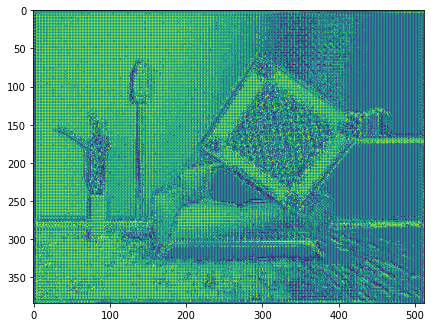

In [20]:
plt.figure(figsize=(7, 7))
plt.imshow(np.argmax(y_h, axis=1).squeeze(), vmin=0, vmax=4)

![tensorcores](https://i.imgur.com/ZEnUntM.png)

The i8816cudnn are tensorcore instructions. And also, the int8 instructions confirm int8 is actually used. 



# Compare

```
pytorch         - val: 0.008589439094066 - time: 4.61 ms
ONNX            - val: 0.008589398115873 - time: N/A
TensorRT 32-bit - val: 0.008589476346969 - time: 2.75 ms
TensorRT 16-bit - val: 0.008575439453125 - time: 2.03 ms
TensorRT  8-bit - val: 0.008526499383151 - time: 1.41 ms
```

This gives me confidence the network will convert properly

# Build

In [1]:
!nbdev_build_lib --fname pytorch_tensorrt_conversion.ipynb

Converted pytorch_tensorrt_conversion.ipynb.
